In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10,10]

In [2]:
df = pd.read_csv('data/2020-07-05-Bayesian-Camera-Calibration/points.csv',sep =' ')
px = df.i.values
py = df.j.values

X_input = df.X.values
Y_input = df.Y.values
Z_input = df.Z.values

number_points = px.shape[0]

points3d = np.vstack([X_input,Y_input,Z_input]).T

In [3]:
def create_rotation_matrix(Q0,Q1,Q2,Q3):
    R =[[Q0**2 + Q1**2 - Q2**2 - Q3**2, 2*(Q1*Q2 - Q0*Q3), 2*(Q0*Q2 + Q1*Q3)],
        [2*(Q1*Q2 + Q0*Q3), Q0**2 - Q1**2 + Q2**2 - Q3**2, 2*(Q2*Q3 - Q0*Q1)],
        [2*(Q1*Q3 - Q0*Q2), 2*(Q0*Q1 + Q2*Q3), (Q0**2 - Q1**2 - Q2**2 + Q3**2)]]
    return(R)

def normalize_quaternions(Q0,Q1,Q2,Q3):
    norm = pm.math.sqrt(Q0**2 + Q1**2 + Q2**2 + Q3**2)
    Q0 /= norm
    Q1 /= norm
    Q2 /= norm
    Q3 /= norm
    return(Q0,Q1,Q2,Q3)

def Rotate_Translate(X_est, Y_est, Z_est):
    Q1 = pm.StudentT('Xq', nu = 1.824, mu = 0.706, sigma = 0.015)
    Q2 = pm.StudentT('Yq', nu = 1.694, mu = -0.298, sigma = 0.004)
    Q3 = pm.StudentT('Zq', nu = 2.015, mu = 0.272, sigma = 0.011)
    Q0 = pm.StudentT('Wq', nu = 0.970, mu = 0.590, sigma = 0.019)
    
    Q0,Q1,Q2,Q3 = normalize_quaternions(Q0,Q1,Q2,Q3)
    
    R = create_rotation_matrix(Q0,Q1,Q2,Q3)
    
    # Define priors 
    X_centroid = pm.Normal('X_centroid', mu = -6.85, sigma = 10)
    Y_centroid = pm.Normal('Y_centroid', mu = -12.92, sigma = 10)
    Z_centroid = pm.Normal('Z_centroid', mu = 2.75, sigma = 10)
    
    RIC_0_3 = R[0][0] * -X_centroid + R[0][1] * -Y_centroid + R[0][2] * -Z_centroid
    RIC_1_3 = R[1][0] * -X_centroid + R[1][1] * -Y_centroid + R[1][2] * -Z_centroid
    RIC_2_3 = R[2][0] * -X_centroid + R[2][1] * -Y_centroid + R[2][2] * -Z_centroid
    
    X_out = X_est * R[0][0] + Y_est * R[0][1] + Z_est * R[0][2] + RIC_0_3
    Y_out = X_est * R[1][0] + Y_est * R[1][1] + Z_est * R[1][2] + RIC_1_3
    Z_out = X_est * R[2][0] + Y_est * R[2][1] + Z_est * R[2][2] + RIC_2_3
    
    return(X_out, Y_out, Z_out)
    

In [4]:
with pm.Model() as model: 
    X, Y, Z = Rotate_Translate(points3d[:,0], points3d[:,1], points3d[:,2])
    
    focal_length = pm.Normal('focal_length',mu = 2191, sigma = 11.50)
    
    k1 = pm.Normal('k1', mu = -0.327041, sigma = 0.5 * 0.327041)
    k2 = pm.Normal('k2', mu = 0.175031,  sigma = 0.5 * 0.175031)
    k3 = pm.Normal('k3', mu = -0.030751, sigma = 0.5 * 0.030751)
    
    c_x = pm.Normal('c_x', mu = 2268/2.0, sigma = 1000)
    c_y = pm.Normal('c_y', mu = 1503/2.0, sigma = 1000)
    
    px_est = X / Z
    py_est = Y / Z
    
    #Radial distortion
    r = pm.math.sqrt(px_est**2 + py_est**2)
    
    radial_distortion_factor = (1 + k1 * r + k2 * r**2 + k3 * r**3)
    px_est *= radial_distortion_factor
    py_est *= radial_distortion_factor
    
    px_est *= focal_length
    py_est *= focal_length

    px_est += c_x
    py_est += c_y
    
    error_scale = 5 #px
    
    delta = pm.math.sqrt((px - px_est)**2 + (py - py_est)**2)
    
    # Define likelihood
    likelihood = pm.Normal('rms_pixel_error', mu = delta, sigma = error_scale, observed=np.zeros(number_points))

    # Inference!
    trace = pm.sample(draws=10_000, init='adapt_diag', cores=4, tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_y, c_x, k3, k2, k1, focal_length, Z_centroid, Y_centroid, X_centroid, Wq, Zq, Yq, Xq]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [1:11:55<00:00, 13.90draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 504x504 with 0 Axes>

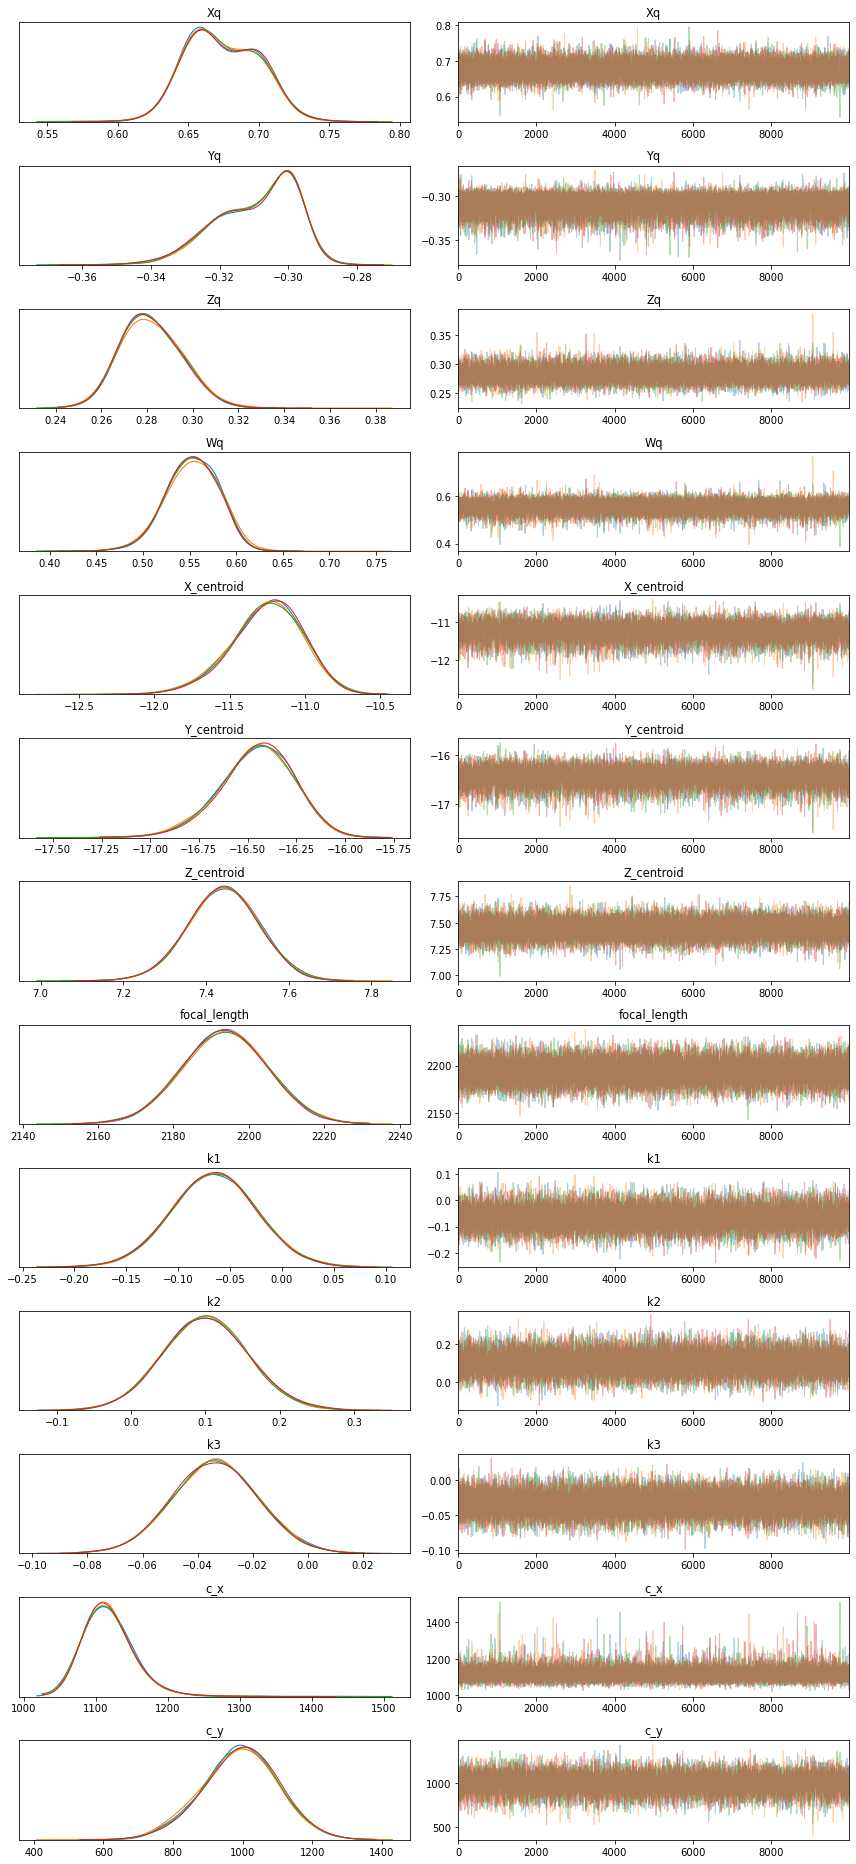

In [5]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace);
plt.tight_layout();

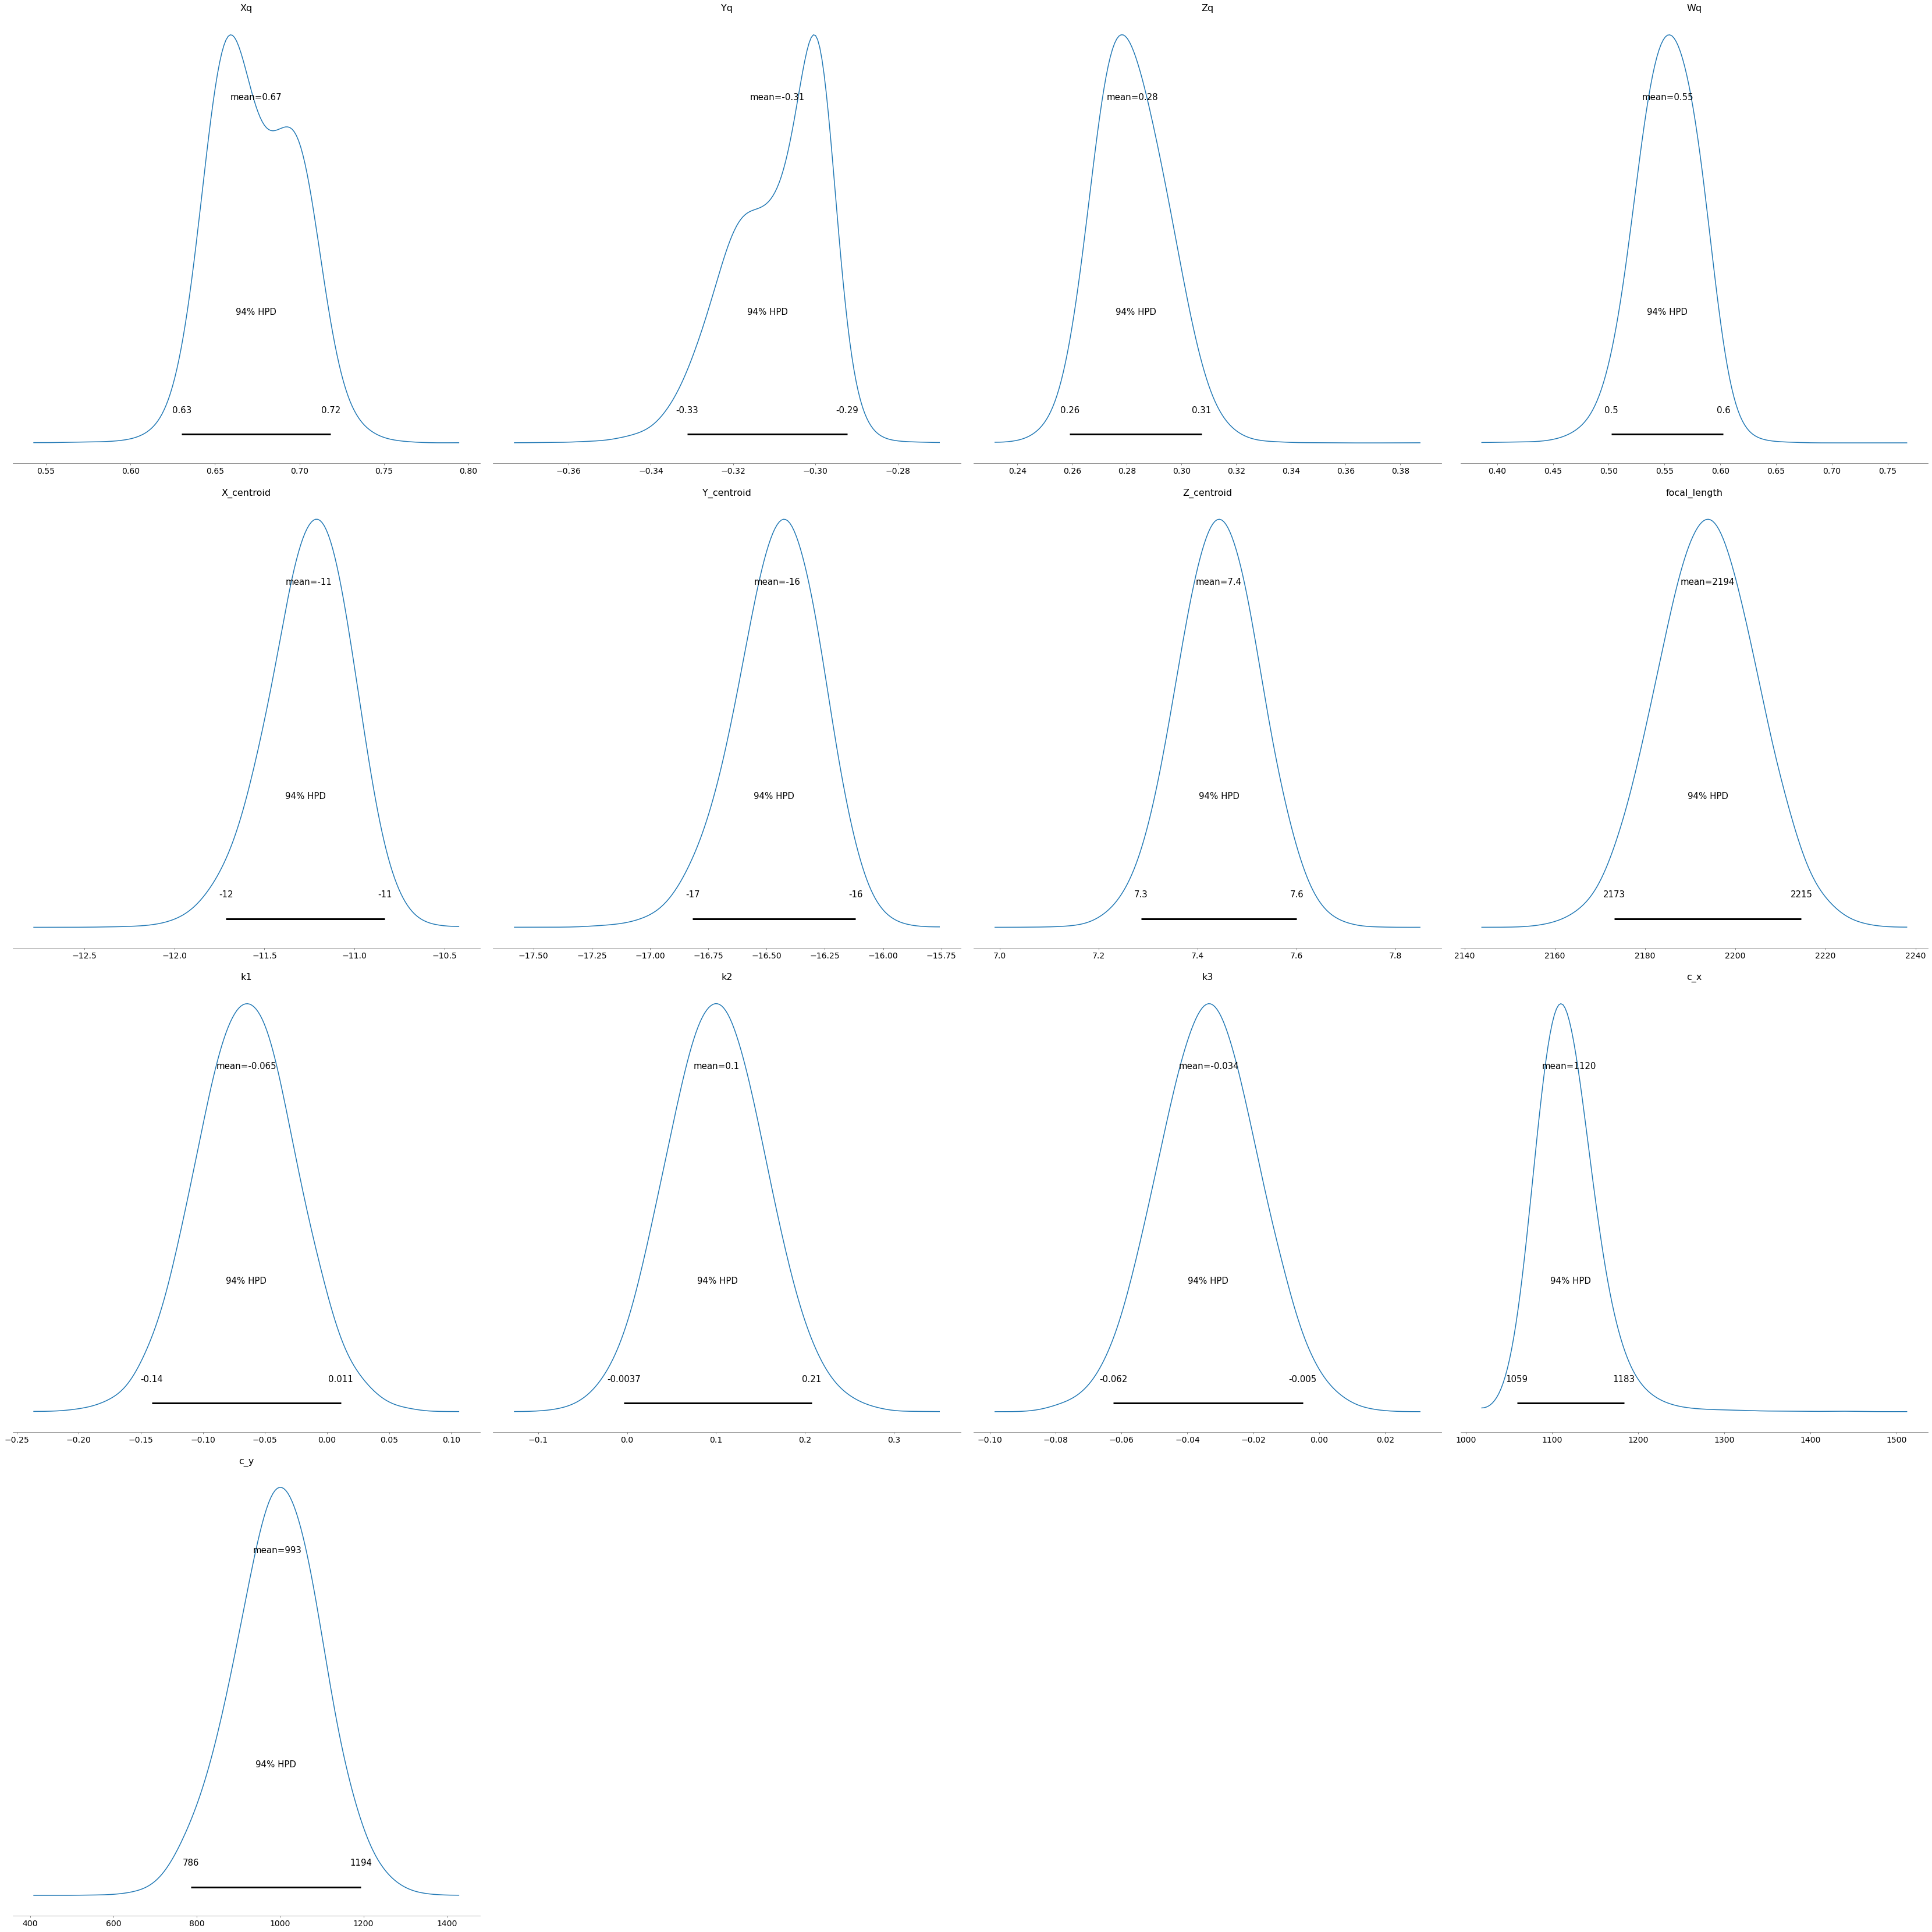

In [6]:
pm.plot_posterior(trace);

In [7]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Xq,0.674,0.025,0.630,0.719,0.000,0.000,11170.0,11170.0,11931.0,17643.0,1.0
Yq,-0.309,0.012,-0.331,-0.292,0.000,0.000,10639.0,10549.0,12481.0,16032.0,1.0
Zq,0.282,0.013,0.259,0.307,0.000,0.000,14060.0,13985.0,14346.0,20241.0,1.0
Wq,0.553,0.028,0.502,0.603,0.000,0.000,10825.0,10825.0,11893.0,12353.0,1.0
X_centroid,-11.255,0.235,-11.714,-10.833,0.002,0.002,9757.0,9748.0,9862.0,13180.0,1.0
Y_centroid,-16.454,0.188,-16.818,-16.118,0.002,0.001,11012.0,10990.0,11271.0,14854.0,1.0
Z_centroid,7.443,0.084,7.286,7.601,0.001,0.000,18893.0,18893.0,19120.0,19610.0,1.0
focal_length,2193.775,11.109,2173.096,2214.626,0.068,0.048,27045.0,27045.0,27044.0,27713.0,1.0
k1,-0.065,0.040,-0.141,0.011,0.000,0.000,14046.0,12577.0,14140.0,17074.0,1.0
k2,0.101,0.056,-0.004,0.207,0.000,0.000,18678.0,18678.0,18655.0,22622.0,1.0


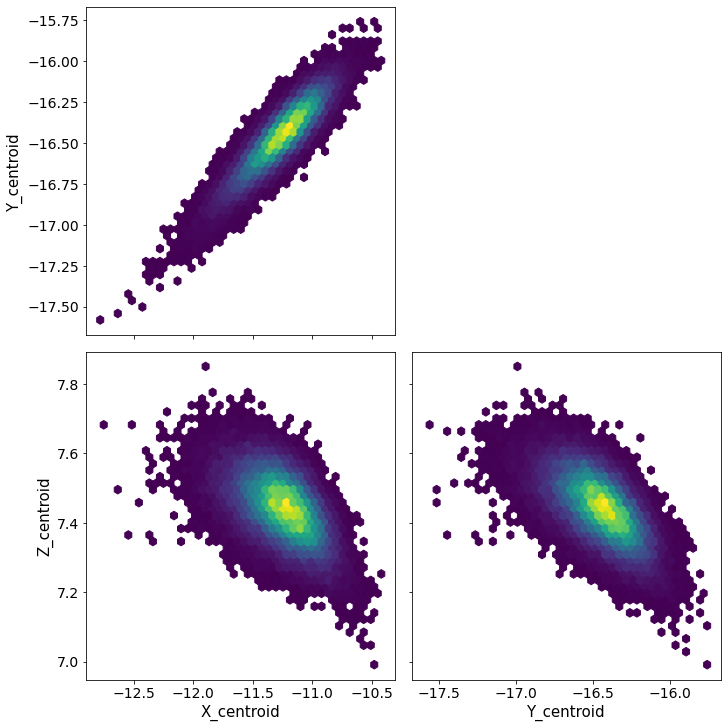

In [19]:
pm.pairplot(trace, kind = 'hexbin', var_names=['X_centroid','Y_centroid','Z_centroid'], divergences=True);

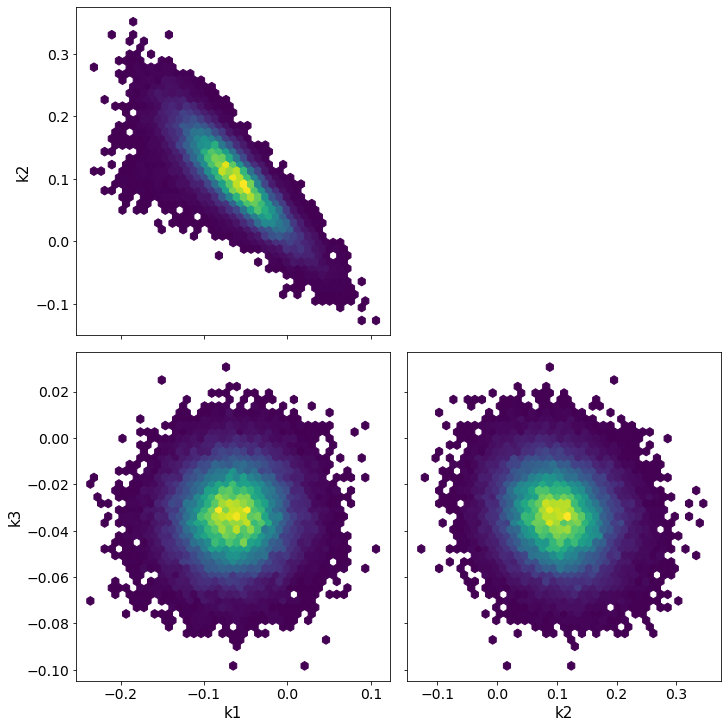

In [20]:
pm.pairplot(trace, kind = 'hexbin', var_names=['k1', 'k2', 'k3'], divergences=True);

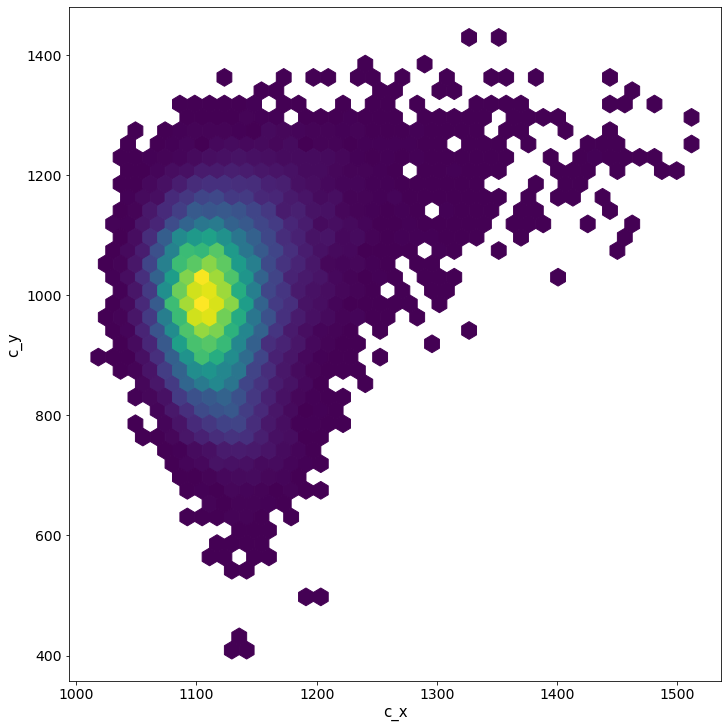

In [29]:
pm.pairplot(trace, kind = 'hexbin', var_names=['c_x', 'c_y'], divergences=True);

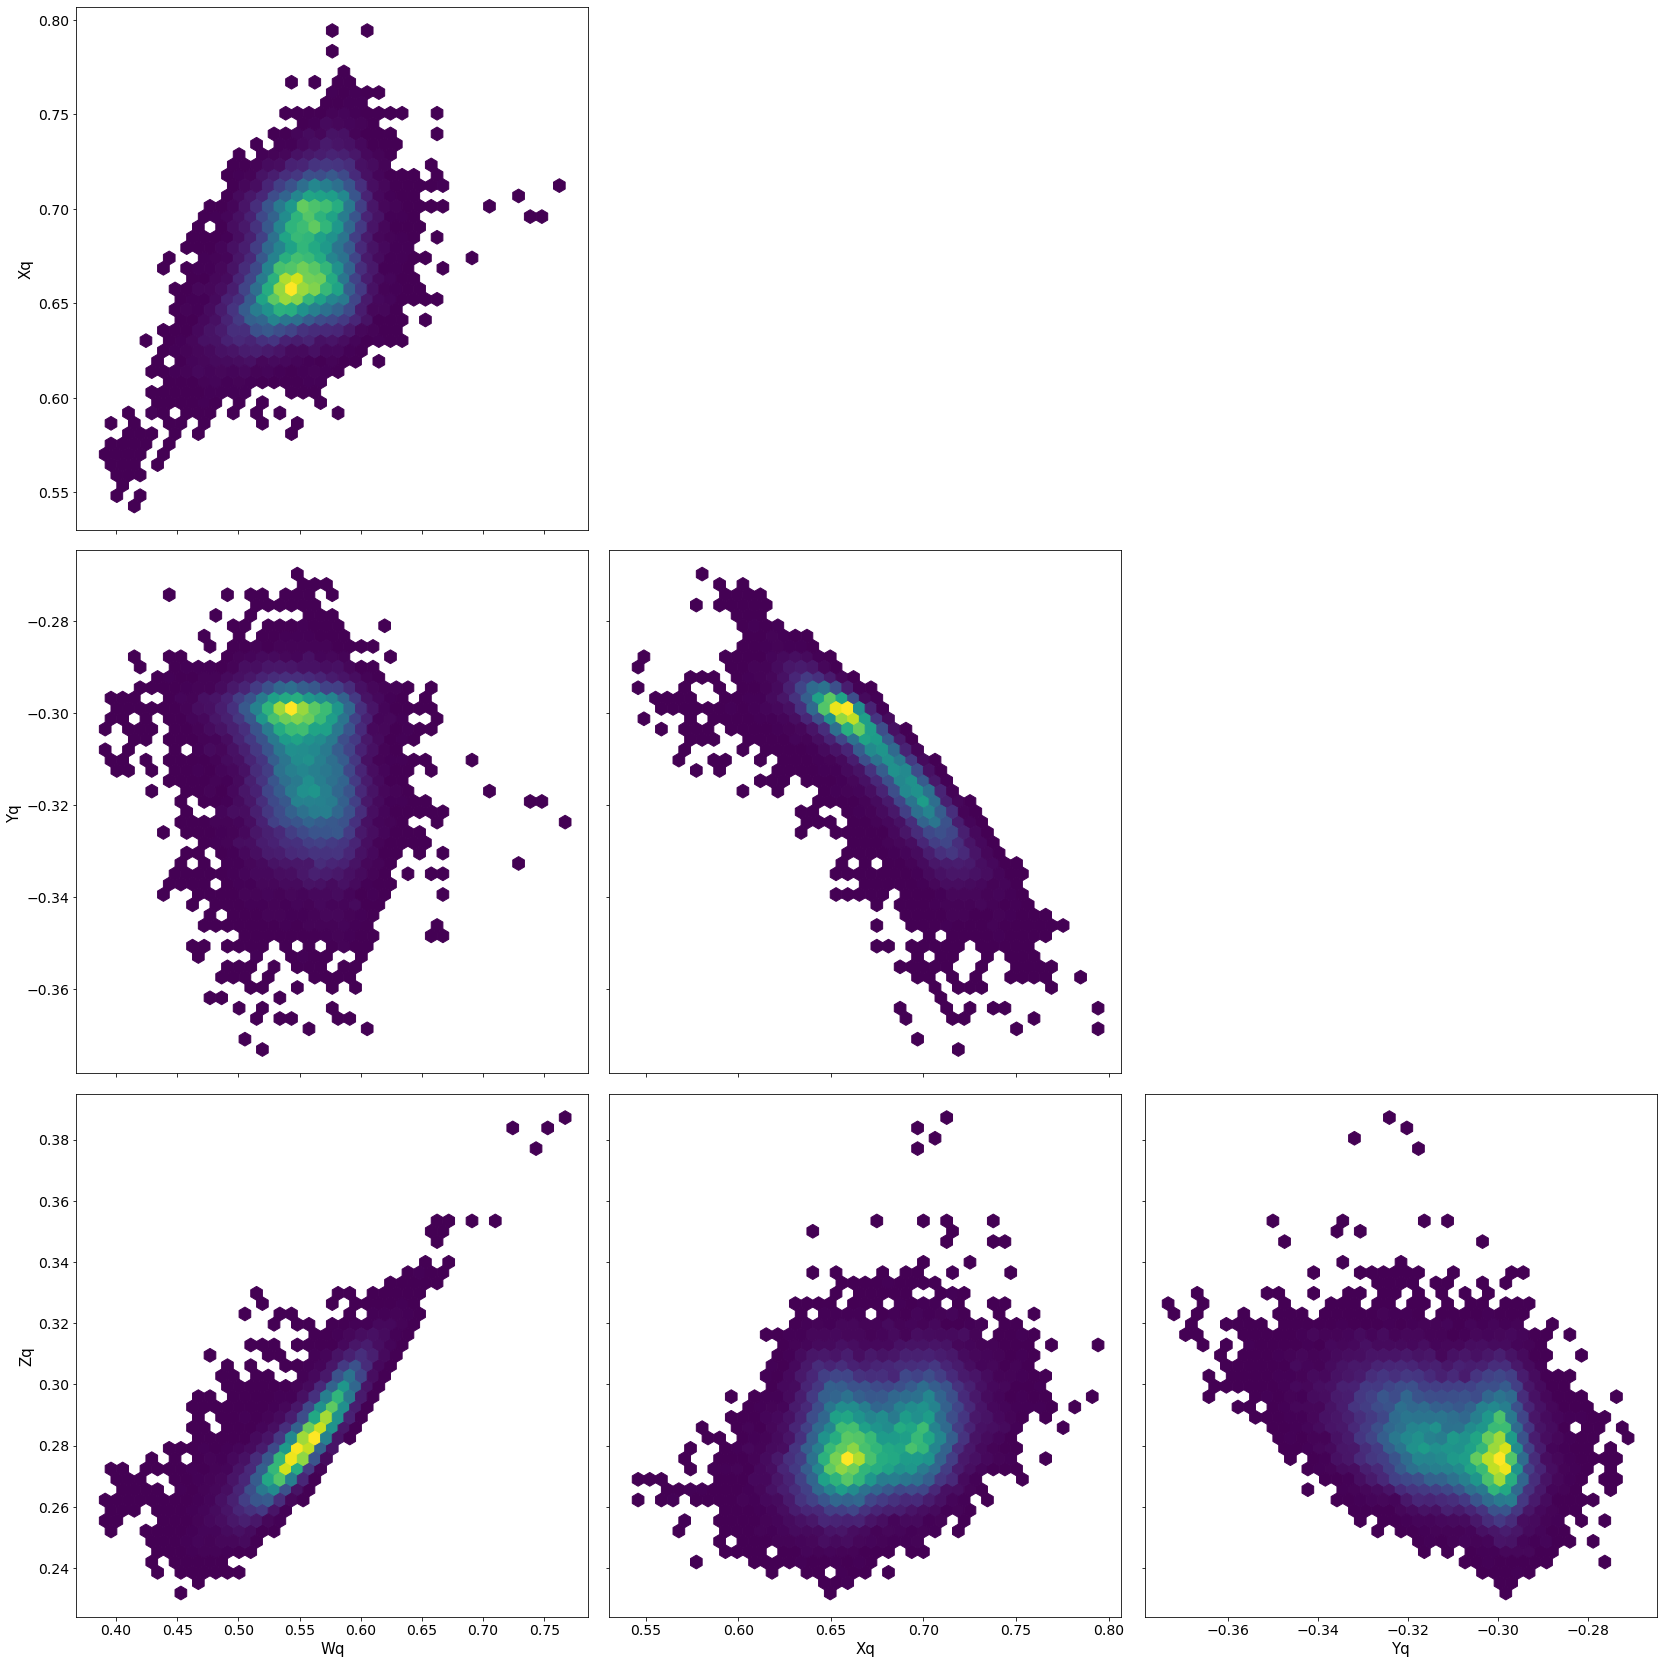

In [22]:
pm.pairplot(trace,kind = 'hexbin', var_names=['Wq', 'Xq','Yq','Zq'], divergences=True);

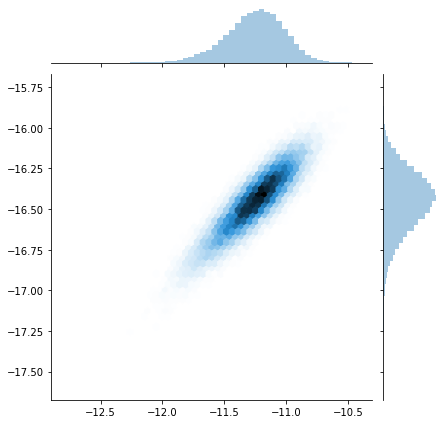

In [23]:
sns.jointplot(trace[:]['X_centroid'], trace[:]['Y_centroid'], kind="hex");

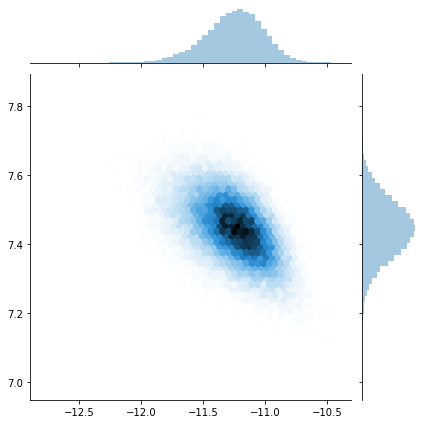

In [24]:
sns.jointplot(trace[:]['X_centroid'], trace[:]['Z_centroid'], kind="hex");

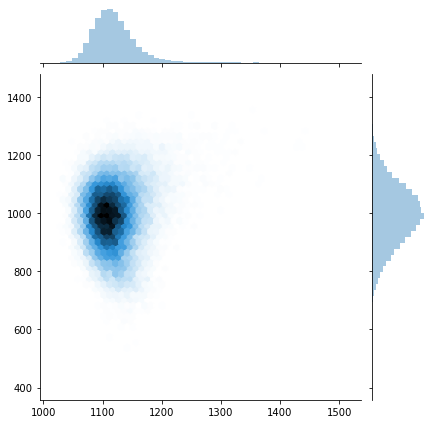

In [25]:
sns.jointplot(trace[:]['c_x'], trace[:]['c_y'], kind="hex");

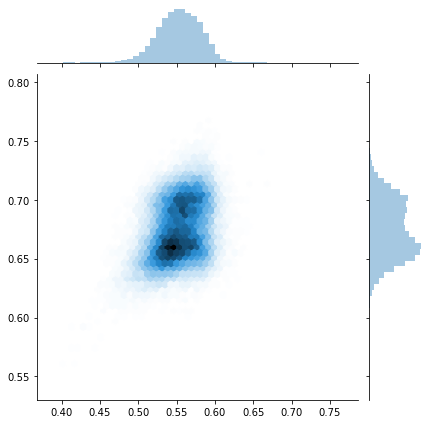

In [26]:
sns.jointplot(trace[:]['Wq'], trace[:]['Xq'], kind="hex");